# TITLE: RL Duelling DQN Atari game
# AUTHOR: EOGHAN O'CONNOR

## Description
#### The following is a DQN and Duelling DQN model trained to play Atlantis Atari video game.
#### These short demonstration  take approximately 4-5hours (Generally take 30hours) to train each model.
#### To prove that learning had taken place with the DQN/ Duelling DQN a control is created with no model showing that without the models no learning takes place.

##### Note: This was ran and tested in colab pro+.


In [ ]:
!pip install gym
!pip install autorom[accept-rom-license]
!pip install gym[accept-rom-license]
!pip install gym[atari]

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.test.gpu_device_name()
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
%tensorflow_version 2.x
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout,Flatten
from collections import deque
from gym import wrappers
from gym.wrappers import FrameStack, GrayScaleObservation, ResizeObservation
import gym
import pickle
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# DQN

### To implement Atari Video game referenced: Open AI gymlibrary Atari [website](https://www.gymlibrary.dev/environments/atari/atlantis/) 

In [ ]:
#Atari video game
env = gym.make('ALE/Atlantis-v5')
env.full_action_space=False
Num_actions = len(np.arange(env.action_space.n))
print('Possible actions:', Num_actions)

Possible actions: 4


/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
# from google.colab import drive
# import numpy as np

# # Mount your Google Drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Hyperparameters
max_episodes = 730
LR = 0.01
DISCOUNT = 0.99
epsilon = 1
EPSILON_DECAY = .99975 # The epsilon decays over the episodes. 
MIN_EPSILON = 0.001
state_size = (84, 84, 4)

In [ ]:
model = Sequential()
model.add(Conv2D(32, (8,8), strides=(4,4), activation='relu', input_shape=state_size))
model.add(Conv2D(64, (4,4), strides=(2,2), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(Num_actions, activation='linear'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(LR), loss='mse', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 20, 32)        8224      
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 128)               401536    
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 480,036
Trainable params: 480,036
Non-trai

In [ ]:
# Function to choose the next action
def get_action(state,current_epsilson):
  #Random exploration
  if np.random.random() < current_epsilson:
    return env.action_space.sample()
  else:
    #Get predicted q values
    q_values = model.predict(state)
    return np.argmax(q_values[0])

In [ ]:
# Function to learn from the memory
def replay(batch_size=64):
  if len(memory) < batch_size:
    return

  prev_memories = random.sample(memory,min(len(memory), batch_size))
  X = []
  y = []

  for current_state, action, reward, next_state, done in prev_memories:
    if not done:
      #Calculate max q value
      max_future_q = np.amax(model.predict(next_state.reshape(1,*state_size)))
      new_q = (reward + DISCOUNT * max_future_q)
    else:
      #Q value is reward value
      new_q = reward
    #Get q values
    current_qs = model.predict(current_state.reshape(1,*state_size))
    current_qs[0][action] = new_q
    X.append(current_state)
    y.append(current_qs[0])
  #Train model using states and corresponding q values
  model.fit(np.array(X), np.array(y), batch_size = len(X),verbose =0)

In [ ]:
#Update exploration minimum value of .1
def update_epsilon(current_epsilson): 
  return max(MIN_EPSILON, current_epsilson*EPSILON_DECAY)

### To implement **preprocess_frame function and the for loop of episodes** referenced Packt chapter 11. 
Deep-Learning-with-TensorFlow-2-and-Keras [github](https://github.com/PacktPublishing/Deep-Learning-with-TensorFlow-2-and-Keras/blob/master/Chapter%2011/DQN_Atari_v2.ipynb) <br>

In [ ]:
 # Function to grayscale and resize image
def preprocess_frame(frame):
    gray = tf.image.rgb_to_grayscale(frame)#convert to grayscale
    resized = tf.image.resize(gray, [84, 84]) #make image smaller 84x84
    return resized.numpy()

In [ ]:
current_epsilson = epsilon
# Memory
rewards = []
memory = deque(maxlen=5000)
rewards = deque(maxlen=2000)
batch_size = 64

for episode in range(1, max_episodes): 
  # Initialize episode variables
  state = env.reset()
  state = preprocess_frame(state)
  state = np.stack([state] * 4, axis=2)
  done = False
  total_reward = 0
  total_steps = 0
  # Episode loop
  while not done:
    # Choose action
    action = get_action(state.reshape(1,84,84,4),current_epsilson)
    #Get next state
    next_state, reward, done, _ = env.step(action)
    #Reshape + grayscale image
    next_state = preprocess_frame(next_state)
    #Stack next_state image on previous state images
    next_state = np.concatenate((next_state.reshape(84, 84, 1), state[:, :, :3].reshape(84, 84, 3)), axis=2)
    #Capture memory instance and append it to memory
    mem_instance = (state.reshape(84,84,4), action, reward, next_state, done)
    memory.append(mem_instance)

    state = next_state
    total_reward += reward
    total_steps += 1
  #if agent is "done" train model 
  replay(batch_size)
  rewards.append(total_reward)
  #Update exploration epsilon
  current_epsilson = update_epsilon(current_epsilson)   
  print(f"Episode:{episode}/{max_episodes} Total reward: {total_reward} Total steps: {total_steps} epsilon: {current_epsilson} memory size: {len(memory)}")
  env.close()

In [ ]:
#Show the average reward over time
def show_ave_reward(rewards):
    # Compute the cumulative sum of the array up to each index
    cumulative_sum = np.cumsum(rewards)

    # Compute the cumulative average of the array up to each index
    cumulative_avg = cumulative_sum / np.arange(1, len(rewards) + 1)

    # Plot the cumulative average
    plt.plot(cumulative_avg)
    plt.title("Average Reward across episodes")
    plt.xlabel("Index")
    plt.ylabel("Cumulative Average")
    plt.show()

### Average reward per episode
The following plot shows the average reward of all cumulative episodes.<br>
We can clearly see the episodes are learning in the later episodes by exploiting previous knowledge.<br>
The earlier episodes vary showing early emphasis on exploration.

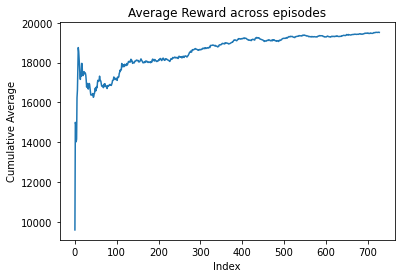

In [ ]:
show_ave_reward(rewards)

### The total rewards vs episodes plot 
Shows each reward for each episode.
Using the line of least squares we can get a representation of the rewards.
The slope of the line is in an upward trajectory. This unorthadox method  proves learning has taken place.

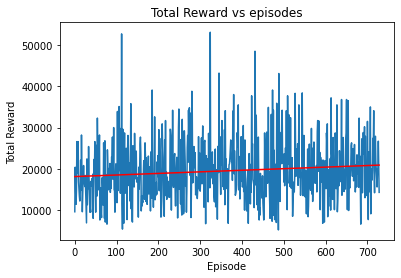

In [ ]:
# Define the average line
episodes = np.arange(len(rewards))
slope, intercept = np.polyfit(episodes, rewards, 1)
plt.plot(rewards)
plt.plot(episodes, slope * episodes + intercept, color='red')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward vs episodes")
plt.show()

In [ ]:
print(f"the slope is {slope} the intercept is {intercept}")

the slope is 3.8219444459931453 the intercept is 18126.507694909524


### **A control game**
Here a random 730 games are played with no model to show the difference with and without RL model.

In [ ]:
rewards = []
for i in range(max_episodes):
    done = False
    total_reward = 0
    state = env.reset()
    while not done:
        action = env.action_space.sample()  # choose a random action
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state
    rewards.append(total_reward)
    print(f"Episode {i+1}, Reward: {total_reward}")

print("Average reward:", np.mean(rewards))

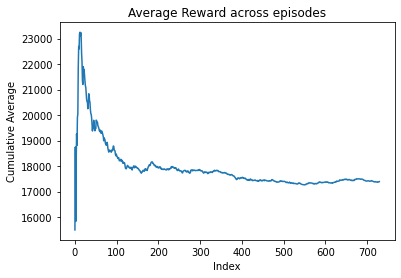

In [ ]:
show_ave_reward(rewards)

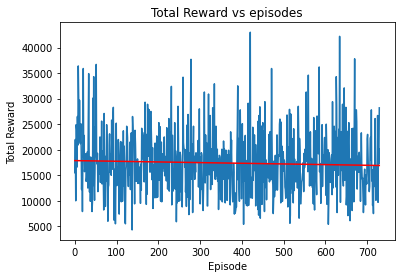

In [ ]:
# Define the average line
episodes = np.arange(len(rewards))
slope, intercept = np.polyfit(episodes, rewards, 1)
plt.plot(rewards)
plt.plot(episodes, slope * episodes + intercept, color='red')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward vs episodes")
plt.show()

In [ ]:
print(f"the slope is {slope} the intercept is {intercept}")

the slope is -1.309020314240338 the intercept is 17870.425575773475


The DQN performs weakly but does shown signs of learning, after 150 episodes it starts converging upawards at a gradual slope.<br>

The slope of the line shows overall improvement throughout the episodes with a slope of 3.8, had there not been a limitation on the hardware (51gb system RAM on colab pro) the DQN would have shown more promise and gotten a better result.<br>
<br>
 A random action game is shown also as a control experiment. There is no gradual performance improvment as expected, thus proving the point that learning has taken place on the DQN although a shortened version compared to published works.

In [ ]:
# # Save the array to Google Drive
# save_path = '/content/drive/My Drive/rewards_DQN.npy'
# np.save(save_path, rewards)

# DUELLING DQN

In [ ]:
# Define the epsilon-greedy policy
def epsilon_greedy(Q, state, epsilon):
    if np.random.random() < epsilon:
        # Choose a random action
        return np.random.randint(4)
    else:
        # Choose the action with highest Q-value
        return np.argmax(Q[state[0], state[1]])

### Duelling DQN and improvements from piers suggestions
pyLessons.com Tutorial: Solving the Cartpole with Dueling Double Deep Q Network [tutorial](https://pylessons.com/CartPole-DDDQN) <br>

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.test.gpu_device_name()
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
%tensorflow_version 2.x
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout,Flatten
from collections import deque
from gym import wrappers
from gym.wrappers import FrameStack, GrayScaleObservation, ResizeObservation
import gym
import pickle
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Hyperparameters
max_episodes = 730
LR = 0.01
DISCOUNT = 0.99
epsilon = 1
EPSILON_DECAY = .99975 # The epsilon decays over the episodes. 
MIN_EPSILON = 0.001
state_size = (84, 84, 4)

In [ ]:
#Atari video game
env = gym.make('ALE/Atlantis-v5')
# wrap the environment to gray Scale Images
env = GrayScaleObservation(env)
# resize the environment frames to 84x84
env = ResizeObservation(env, (84, 84))
# wrap the environment with the FrameStack wrapper
env = FrameStack(env, num_stack=4)
env.full_action_space=False
Num_actions = len(np.arange(env.action_space.n))
print('Possible actions:', Num_actions)

Possible actions: 4


/usr/local/lib/python3.9/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/utils/passive_env_checker.py:297: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


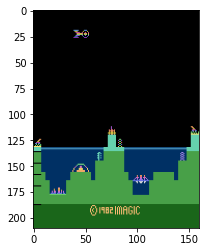

In [ ]:
#viewing game
env.reset()
img = env.render(mode='rgb_array')
plt.imshow(img)

In [ ]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHTFIRE', 'LEFTFIRE']

In [ ]:
from keras.models import Model, load_model
from keras.layers import Input, Dense, Lambda, Add, Conv2D, Flatten
from keras.optimizers import Adam, RMSprop
from keras import backend as K

### To Implement duelling method in create_model referred to pyLessons.com Tutorial: Solving the Cartpole with Dueling Double Deep Q Network [tutorial](https://pylessons.com/CartPole-DDDQN) <br>

In [ ]:
#Function to create Duelling DQN Models
def create_model (name,duelling=False):
  input_shape = (84, 84, 4)
  action_space = Num_actions
  inputs  = Input(shape=input_shape)

  conv_ = Conv2D(32, kernel_size=8, strides=4, padding='same')(inputs)
  conv_ = Conv2D(64, kernel_size=4, strides=2, padding='same')(conv_)
  conv_ = Conv2D(64, kernel_size=3, strides=2, padding='same')(conv_)
  flatten = Flatten()(conv_)

  dense =  Dense(128,activation="relu",kernel_initializer="he_uniform" )(flatten)

  #For Duelling DQN model
  if duelling:
    #Get state value
    state_value = Dense(1,kernel_initializer='he_uniform')(dense)
    state_value = Lambda(lambda s: K.expand_dims(s[:, 0], -1), output_shape=(action_space,))(state_value)

    #Action adavantage
    action_advantage = Dense(action_space,kernel_initializer='he_uniform')(dense)
    action_advantage = Lambda(lambda a: a[:, :] - K.mean(a[:, :], keepdims=True), output_shape=(action_space,))(action_advantage)
    #Adding layers back together
    penultimate_layer = Add()([state_value,action_advantage])

  # For Double DQN model
  else:
    penultimate_layer = Dense(128, activation='relu',kernel_initializer="he_uniform")(dense)

  final_layer = Dense(Num_actions, activation = "linear", kernel_initializer='he_uniform')(penultimate_layer)
  model = Model(inputs =inputs, outputs = final_layer,name=name)
  return model

In [ ]:
model = create_model("duelling_model",duelling=True)
model.compile(optimizer=tf.keras.optimizers.Adam(LR), loss='mse', metrics=['accuracy'])

### Duelling DQN architecture

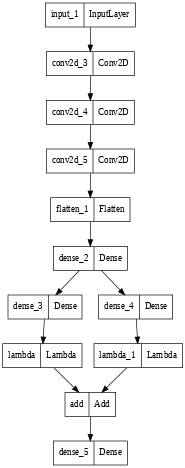

In [ ]:
keras.utils.plot_model(model, dpi=48)

In [ ]:
# Function to reoder the frames and shape of the image
def preprocess_frame(frame):
  frame = np.array(frame)
  transposed_frame = np.transpose(frame, (3, 1, 2, 0))
  return transposed_frame

### To implement **get_action, replay and update_epsilon** functions referred to Sentdex python programming training-deep-q-learning-dqn-reinforcement-learning-python-tutorial [tutorial](https://pythonprogramming.net/training-deep-q-learning-dqn-reinforcement-learning-python-tutorial/) <br>

In [ ]:
# Function to choose the next action
def get_action(state,current_epsilson):
  #Random exploration
  if np.random.random() < current_epsilson:
    return env.action_space.sample()
  else:
    #Predict the q value
    q_values = model.predict(state)
    return np.argmax(q_values[0])

In [ ]:
# Function to learn from the memory
def replay(batch_size=64):
  if len(memory) < batch_size:
    return

  prev_memories = random.sample(memory,min(len(memory), batch_size))
  X = []
  y = []
  
  for current_state, action, reward, next_state, done in prev_memories:
    if not done:
      #Get max potential q value
      max_future_q = np.amax(model.predict(next_state.reshape(1,*state_size)))
      new_q = (reward + DISCOUNT * max_future_q)
    else:
      #Q value is reward if agent is done
      new_q = reward
    #Get current values
    current_qs = model.predict(current_state.reshape(1,*state_size))
    current_qs[0][action] = new_q
    X.append(current_state)
    y.append(current_qs[0])
  #Train the model using the states and the corresponding q values.
  model.fit(np.array(X), np.array(y), batch_size = len(X),verbose =0)

In [ ]:
#Update exploration minimim value of .1
def update_epsilon(current_epsilson):  
  return max(MIN_EPSILON, current_epsilson*EPSILON_DECAY)

In [ ]:
rewards = []
steps_taken = []
batch_size = 64

### To implement **preprocess_frame function and the for loop of episodes** referenced Packt chapter 11. 
Deep-Learning-with-TensorFlow-2-and-Keras [github](https://github.com/PacktPublishing/Deep-Learning-with-TensorFlow-2-and-Keras/blob/master/Chapter%2011/DQN_Atari_v2.ipynb) <br>

### Implemented **suggestion** made by [Phil Davitt](https://sulis.ul.ie/portal/site/ae959770-e9c8-4608-bfaf-5b42211d7753/tool/c70e2ee4-cca1-4567-8b70-cd1c32949ee3/discussionForum/message/dfAllMessages) (in conversation Etivity3: Task 2 Eoghan O'Connor)  to keep epsilon at 1 for a number of episodes before decaying.

In [ ]:
current_epsilson = epsilon
# Memory
memory = deque(maxlen=5000)

for episode in range(1, max_episodes): 
  # Initialize episode variables
  state = env.reset()
  state = preprocess_frame(state)
  done = False
  total_reward = 0
  total_steps = 0
  # Episode loop
  while not done:
    # Choose action
    action = get_action(state,current_epsilson)
    #Get Next state
    next_state, reward, done, _ = env.step(action)
    #Reshape the frames of the image
    next_state = preprocess_frame(next_state)
    #Make a memory instances and append it to the memory
    mem_instance = (state[0], action, reward, next_state[0], done)
    memory.append(mem_instance)

    state = next_state
    total_reward += reward
    total_steps += 1
  #if agent is "done" train model 
  replay(batch_size)
  #Only reduce the epsilon of exploration after 100 episodes.
  if episode > 100:
    current_epsilson = update_epsilon(current_epsilson)   
  print(f"Episode:{episode}/{max_episodes} Total reward: {total_reward} Total steps: {total_steps} epsilon: {current_epsilson} memory size: {len(memory)}")
  steps_taken.append(total_steps)
  rewards.append(total_reward)
env.close()

### Implemented **suggestion** made by [Raymond Mc Creesh](https://sulis.ul.ie/portal/site/ae959770-e9c8-4608-bfaf-5b42211d7753/tool/c70e2ee4-cca1-4567-8b70-cd1c32949ee3/discussionForum/message/dfAllMessages) (in conversation Etivity3: Task 2 Eoghan O'Connor) to plot the average reward and show the slope of the learning.

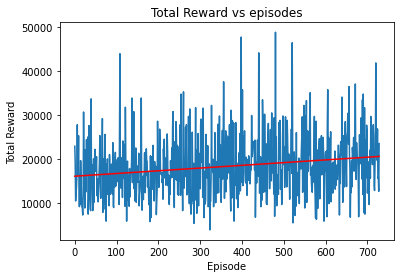

In [ ]:
# Get the line of least squares for the rewards
#An elevated slope shows training is occuring.
episodes = np.arange(len(rewards))
slope, intercept = np.polyfit(episodes, rewards, 1)
plt.plot(rewards)
plt.plot(episodes, slope * episodes + intercept, color='red')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward vs episodes")
plt.show()

In [ ]:
print(f"the slope is {slope} the intercept is {intercept}")

the slope is 6.200936162884425 the intercept is 16053.558825187436


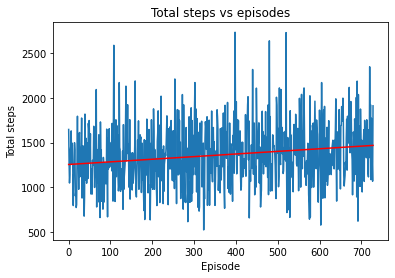

In [ ]:
step_slope, step_intercept = np.polyfit(episodes, steps_taken, 1)
plt.plot(steps_taken)
plt.plot(episodes, step_slope * episodes + step_intercept, color='red')
plt.xlabel("Episode")
plt.ylabel("Total steps")
plt.title("Total steps vs episodes")
plt.show()

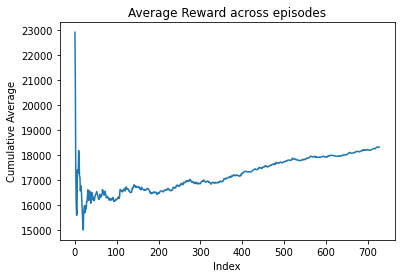

In [ ]:
show_ave_reward(rewards)

### Reflection
The Duelling DQN shows a learning ability that is accelerating nearing twice that of the vanilla DQN. As shown in the slope of the line for the Duelling DQN is 6.2 while the DQN is 3.82. <br>
The score average score of the DQN is slightly better but this is due to random chance with the earlier episodes while kept the average up. Once the heavy exploration phases where finished the duelling outperforms the DQN.

In [ ]:
# # Save the array to Google Drive
# save_path = '/content/drive/My Drive/rewards_DDQN2.npy'
# np.save(save_path, rewards)

# Improving the Duelling DQN
### Do an empirical study of hpyerparameters
### The 4 hyperparameters are learning rate, discount, exploration rate (decay) and batch size.

### To test these a shortened training environment will be conducted.
### Firstly, identifying what is the least amount of steps can be taken to possibly show learning. This was 750 steps.

### Second, A control model of the shortened test is created. To better compare results.

### Finally, a model is created for each parameter change to see its effects.

In [ ]:
!pip install gym pyvirtualdisplay opencv-python-headless
!apt-get install -y xvfb x11-utils

###Expriment to find ideal number of max steps to learn from. result: 750 steps 
Due to Colab limitations i.e. cant render atari videos or use gym.monitor instead a while loop displaying each frame individually is implemented.<br>
<br>
Note this does show the game playing only at a very low FPS.

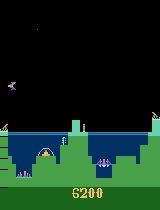

In [ ]:
import gym
from gym.wrappers import AtariPreprocessing
import numpy as np
from pyvirtualdisplay import Display
from IPython.display import clear_output, display
import PIL.Image
import os

# create a virtual display to render Atari game
display_ = Display(visible=0, size=(1400, 900))
display_.start()

# create Atari game environment and preprocess it
env = gym.make('ALE/Atlantis-v5')
# env = AtariPreprocessing(env, screen_size=84, grayscale_obs=True)

# reset the environment
obs = env.reset()
steps = 0
# loop to display the game
done = False
while steps < 750:
    # render the game frame
    frame = env.render(mode='rgb_array')

    # display the game frame
    clear_output(wait=True)
    display(PIL.Image.fromarray(frame))

    # take an action and get the next observation
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    steps +=1
env.close()

# stop the virtual display
display_.stop()

In [ ]:
#Atari video game
env = gym.make('ALE/Atlantis-v5')
# wrap the environment to gray Scale Images
env = GrayScaleObservation(env)
# resize the environment frames to 84x84
env = ResizeObservation(env, (84, 84))
# wrap the environment with the FrameStack wrapper
env = FrameStack(env, num_stack=4)
env.full_action_space=False
Num_actions = len(np.arange(env.action_space.n))
print('Possible actions:', Num_actions)

In [ ]:
# Hyperparameters
max_steps = 750 #Addition paramter to limit training as explained above
max_episodes = 400 # Limiting the number of episodes for training
LR = 0.01 # learning rate
DISCOUNT = 0.99
epsilon = 1
EPSILON_DECAY = .99975 # The epsilon decays over the episodes. 
MIN_EPSILON = 0.001
state_size = (84, 84, 4)

In [ ]:
#Function to run the agent in environment, train, and learn
def enviroment(input_model,max_steps=500,batch_size=64):
  current_epsilson = epsilon
  rewards = []
  steps_taken = []
  batch_size = batch_size
  #Model set globlly
  global model
  model = input_model
  # Memory
  global memory
  memory = deque(maxlen=5000)

  for episode in range(1, max_episodes): 
    # Initialize episode variables
    state = env.reset()
    state = preprocess_frame(state)
    done = False
    total_reward = 0
    total_steps = 0
    # Episode loop
    while not done and total_steps < max_steps:
      # Choose action
      action = get_action(state,current_epsilson)
      #Get Next state
      next_state, reward, done, _ = env.step(action)
      #Reshape the frames of the image
      next_state = preprocess_frame(next_state)
      #Make a memory instances and append it to the memory
      mem_instance = (state[0], action, reward, next_state[0], done)
      memory.append(mem_instance)

      state = next_state
      total_reward += reward
      total_steps += 1
    #if agent is "done" train model  
    replay(batch_size)
    #Only reduce the epsilon of exploration after 100 episodes.
    if episode > 100:
      current_epsilson = update_epsilon(current_epsilson)   
    print(f"Episode:{episode}/{max_episodes} Total reward: {total_reward} Total steps: {total_steps} epsilon: {current_epsilson} memory size: {len(memory)}")
    steps_taken.append(total_steps)
    rewards.append(total_reward)
  env.close()
  return rewards, steps_taken

In [ ]:
#Function to plot the total rewards per episode
def plotting(values,name):
  episodes = np.arange(len(values))
  #Calculate the slop and intercept of the line of least squares
  slope, intercept = np.polyfit(episodes, values, 1)
  plt.plot(values)
  #plot line
  plt.plot(episodes, slope * episodes + intercept, color='red')
  plt.xlabel("Episode")
  plt.ylabel(f"Total {name}")
  plt.title(f"Total {name} vs episodes")
  plt.show()
  print(f"the slope is {slope} the intercept is {intercept}")


## Below is a control model for the short training
The results from this can be compared to the rest

In [ ]:
# Hyperparameters changing batch size
#Started at 21:23 - 22:35 1hour
BATCH_SIZE = 64
Control_model = create_model("Control_model",duelling=True)
Control_model.compile(loss="mean_squared_error", optimizer=Adam(lr=LR), metrics=["accuracy"])
all_rewards, all_steps = enviroment(Control_model,max_steps=max_steps,batch_size=BATCH_SIZE)

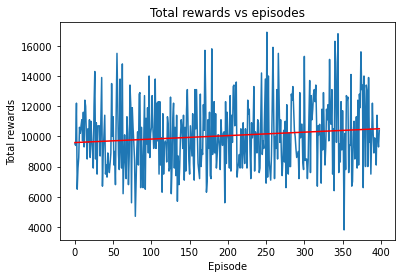

the slope is 2.301337514640892 the intercept is 9589.151629072678


In [ ]:
plotting(all_rewards,"rewards")

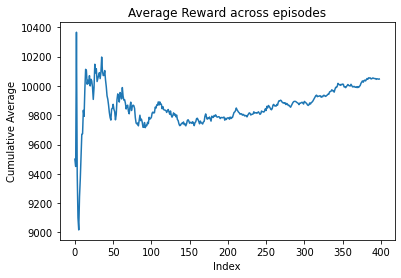

In [ ]:
show_ave_reward(all_rewards)

In [ ]:
# # Save the array to Google Drive
# save_path = '/content/drive/My Drive/rewards_control_DDQN.npy'
# np.save(save_path, all_rewards)

## Decreasing the Exploration decay
### Observations
Exploration value set to .995. Orignally was .99975<br>
The orignal gives a slower decay rate finishing at .883 in 400 episodes.<br>
The experimental decays much faster finishing at after 400 episodes<br>
Training time increased to 3hours orignally 1hour 10mins. <br>
We can see in the plots that performance has dropped dramatically, negative slope and an average reward that seems to hover at 10,000 after 150 episodes.

In [ ]:
# Hyperparameters
EPSILON_DECAY = .995 # The epsilon decays over the episodes. 

In [ ]:
Duel_model_low_epsilon = create_model("Duel_model_low_epsilon",duelling=True)
Duel_model_low_epsilon.compile(loss="mean_squared_error", optimizer=Adam(lr=LR), metrics=["accuracy"])
all_rewards, all_steps = enviroment(Duel_model_low_epsilon,max_steps)

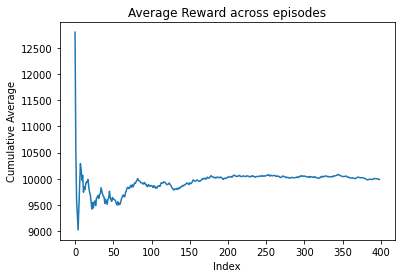

In [ ]:
show_ave_reward(all_rewards)

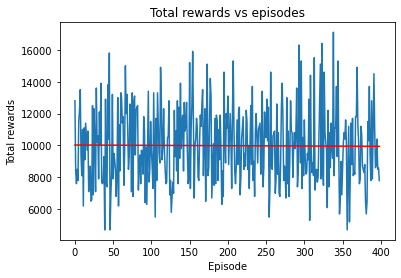

the slope is -0.20238410095588624 the intercept is 10024.98621553884


In [ ]:
plotting(all_rewards,"rewards")

In [ ]:
# # Save the array to Google Drive
# save_path = '/content/drive/My Drive/rewards_Duel_model_low_epsilon_del.npy'
# np.save(save_path, all_rewards)

## Decreasing the Discount (gamma)
### Observations
Discount value set to .95. Orignally was .99<br>
The agent is prioritizing the immediate reward more<br>
This has made the agent perform poorly across time. <br> As shown after episode 200 the theres a steady decline in the average score. The -2.3 <br> slope shown in the total average is shows this is the worst learning performance of the models.

In [ ]:
# Hyperparameters
DISCOUNT = 0.95 # Discount of future values 

In [ ]:
Duelling_model_low_discount = create_model("duelling_modelow_discount",duelling=True)
Duelling_model_low_discount.compile(loss="mean_squared_error", optimizer=Adam(lr=LR), metrics=["accuracy"])
all_rewards, all_steps = enviroment(Duelling_model_low_discount,max_steps=max_steps)


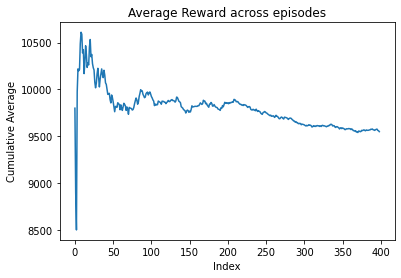

In [ ]:
show_ave_reward(all_rewards)

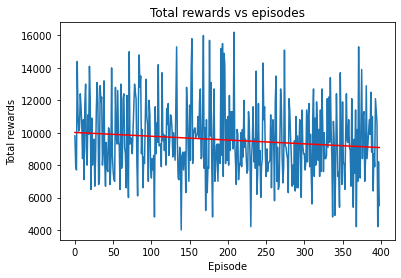

the slope is -2.3403672497827275 the intercept is 10015.357142857136


In [ ]:
plotting(all_rewards,"rewards")

In [ ]:
# # Save the array to Google Drive
# save_path = '/content/drive/My Drive/rewards_Duel_model_low_discount.npy'
# np.save(save_path, all_rewards)

## Decreasing the batch size
### Observations
Batch size value set to 32. Orignally was 64<br>
The model learns better than the control model.<br>
Although the model reaches a slightly lower average score in the end (9800 approx.) than the control (above 10k) the slope of low batch model is steeper showing a greater potential performance.<br>
**Note:** by reducing the batch size the training quickened by approx. 20 mins (25% improvement)


In [ ]:
# Hyperparameters changing batch size
#Consumed 10Gb very 1hour20 ish
BATCH_SIZE = 32
Duelling_model_low_batch = create_model("Duelling_model_low_batch",duelling=True)
Duelling_model_low_batch.compile(loss="mean_squared_error", optimizer=Adam(lr=LR), metrics=["accuracy"])
all_rewards, all_steps = enviroment(Duelling_model_low_batch,max_steps=max_steps,batch_size=BATCH_SIZE)


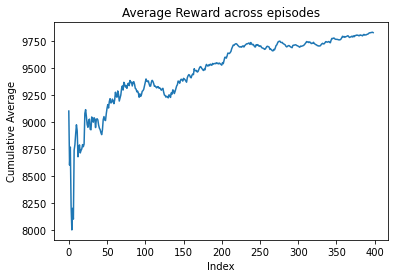

In [ ]:
show_ave_reward(all_rewards)

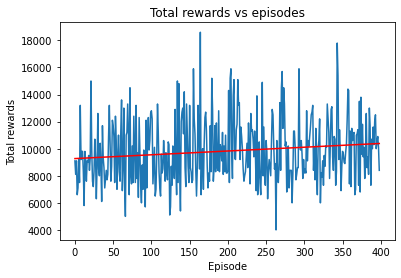

the slope is 2.7973136358484205 the intercept is 9269.149122807015


In [ ]:
plotting(all_rewards,"rewards")

In [ ]:
# # Save the array to Google Drive
# save_path = '/content/drive/My Drive/rewards_Duel_model_low_batch.npy'
# np.save(save_path, all_rewards)

## Decreasing the learning rate
### Observations
Learning rate value set to .00025. Orignally was .01<br>
Lowering the LR would raise concerns that it might not work but it has.<br> We can see that it has a slow learning process but does improve in the later episodes. <br>The slope is very small but theres less average reward variation from the slope. This could potentially outperform the control model for a long training session but not for the shorter sessions.

In [ ]:
# Hyperparameters changing batch size
#Consumed 10Gb very 1hour20 ish
low_LR = .00025
Duelling_model_low_lr = create_model("Duelling_model_low_lr",duelling=True)
Duelling_model_low_lr.compile(loss="mean_squared_error", optimizer=Adam(lr=low_LR), metrics=["accuracy"])
all_rewards, all_steps = enviroment(Duelling_model_low_lr,max_steps=max_steps)


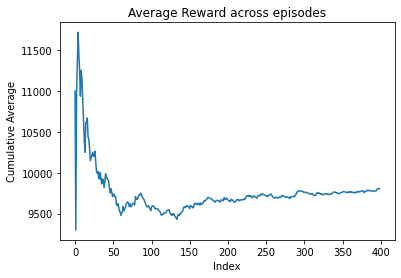

In [ ]:
show_ave_reward(all_rewards)

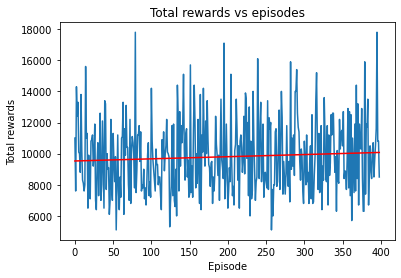

the slope is 1.3736728756564753 the intercept is 9529.395989974935


In [ ]:
plotting(all_rewards,"rewards")

In [ ]:
# # Save the array to Google Drive
# save_path = '/content/drive/My Drive/rewards_Duel_model_low_lr.npy'
# np.save(save_path, all_rewards)

# Conclusion
We can see that the original parameters were fairly optimal bar the batch size. A smaller batch reduces the compuational load but reduces the samples the model is trained on. This therefore is a balancing act, trying to make it train on the smallest batch size while retaining the integrity of good training. A lower exploration rate and discount is not ideal as they prevented training, showing the model worsening over time. <br>
The low learning rate is not ideal for these short training sessions but could eventually outperform the control if computation valability was not a limiting factor.<br>
<br>
The Duelling DQN showed a learning ability that is accelerating nearing twice that of the vanilla DQN. As shown in the slope of the line for the Duelling DQN is 6.2 while the DQN is 3.82.
The score average score of the DQN is slightly better but this is due to random chance with the earlier episodes while kept the average up. Once the heavy exploration phases where finished the duelling outperforms the DQN.
<br>
With a small batch size of 32 the model can be improved for further work.